# Lab 3: Знайомство з нейромережами
### Шевченко Юлія, ФІ-31мн

### Lab Task:

1. _**Повнозв'язані нейронні мережі**_. Вирішити завдання класифікації даних, з якими працювали в лабораторній №1 за допомогою повнозв’язаної нейромережі прямого поширення (fully connected feed-forward network). Результати порівняти з одержаними раніше.
2. _**Згорткові нейронні мережі**_. Вирішити завдання класифікації зображень за допомогою згорткової (convolutional) нейромережі (якщо в обраному датасеті класів забагато, достатньо залишити 3-5).
3. _**Рекурентні нейронні мережі**_. Вирішити задачу класифікації текстів (з якими працювали в лабораторній №2) за допомогою рекурентної нейромережі. Результати порівняти з одержаними раніше. 

In [1]:
# All the imports for the task
import os
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.src.preprocessing.image import ImageDataGenerator
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

### Fully connected feed-forward network

In [2]:
# Loading dataset from csv
spotify_data = pd.read_csv('../Lab_3/song_data.csv')

In [3]:
# Showing the dataset
spotify_data.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [4]:
# Showing the dataset columns
print('The dataset contains such columns: {}'.format(spotify_data.columns))

The dataset contains such columns: Index(['song_name', 'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')


In [5]:
# Some columns have 'int64' type, so we convert them to float
spotify_data.song_duration_ms = spotify_data.song_duration_ms.astype(float)
spotify_data.audio_mode = spotify_data.audio_mode.astype(float)
spotify_data.time_signature = spotify_data.time_signature.astype(float)

In [6]:
# Considering song is popular if song_popularity value is >= 70
spotify_data['popularity'] = [1 if value >= 70 else 0 for value in spotify_data.song_popularity]
spotify_data.popularity.value_counts()

popularity
0    14384
1     4451
Name: count, dtype: int64

In [7]:
# Choosing numeric data and describing correlation
spotify_data_numeric = spotify_data.select_dtypes(include = ['float64', 'int64'])
data_correlation = spotify_data_numeric.corr()
data_correlation

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,popularity
song_popularity,1.000000,-0.018899,-0.065181,0.104290,0.001365,-0.130907,-0.013160,-0.038937,0.099442,-0.004969,0.021479,-0.022672,0.034983,-0.052895,0.660385
song_duration_ms,-0.018899,1.000000,-0.097882,-0.104985,0.092688,-0.015188,-0.004615,0.016086,0.016469,-0.026328,-0.083447,0.012791,0.000264,-0.063421,0.005092
acousticness,-0.065181,-0.097882,1.000000,-0.182500,-0.662639,0.173098,-0.002025,-0.082537,-0.557744,0.064100,-0.093574,-0.136421,-0.157177,-0.121670,-0.101694
danceability,0.104290,-0.104985,-0.182500,1.000000,0.044373,-0.130483,0.007723,-0.090694,0.177639,-0.106539,0.213728,-0.121286,0.136391,0.332014,0.117811
energy,0.001365,0.092688,-0.662639,0.044373,1.000000,-0.205914,0.020416,0.167143,0.755516,-0.051605,0.062053,0.162448,0.146265,0.316742,0.042833
instrumentalness,-0.130907,-0.015188,0.173098,-0.130483,-0.205914,1.000000,-0.009463,-0.032887,-0.390248,-0.014983,-0.081138,-0.036934,-0.069181,-0.178570,-0.152954
key,-0.013160,-0.004615,-0.002025,0.007723,0.020416,-0.009463,1.000000,-0.008193,0.010452,-0.169848,0.033639,0.003239,-0.008282,0.025356,-0.021929
liveness,-0.038937,0.016086,-0.082537,-0.090694,0.167143,-0.032887,-0.008193,1.000000,0.102450,-0.001035,0.090845,0.031876,0.013289,0.013789,-0.025308
loudness,0.099442,0.016469,-0.557744,0.177639,0.755516,-0.390248,0.010452,0.102450,1.000000,-0.058506,0.078164,0.129938,0.119241,0.199696,0.145254
audio_mode,-0.004969,-0.026328,0.064100,-0.106539,-0.051605,-0.014983,-0.169848,-0.001035,-0.058506,1.000000,-0.111627,0.020448,-0.024042,-0.004558,-0.019096


In [8]:
# Splitting data to train and test with 20% test data size
X = spotify_data_numeric.drop(['popularity'], axis=1)
y = spotify_data_numeric['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
# Standardize the variables
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [10]:
# Creating model
model = Sequential()
model.add(Dense(64, input_dim=scaled_X_train.shape[1], activation='relu'))  # First connected layer
model.add(Dense(32, activation='relu'))  # Second connected layer
model.add(Dense(1, activation='sigmoid'))  # Sigmoid output layer for binary classification

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
# Train model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
model.fit(scaled_X_train, y_train, epochs=100, batch_size=32, validation_data=(scaled_X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
471/471 [==============================] - 1s 2ms/step - loss: 0.1684 - accuracy: 0.9352 - val_loss: 0.0756 - val_accuracy: 0.9721
Epoch 2/100
471/471 [==============================] - 1s 1ms/step - loss: 0.0559 - accuracy: 0.9786 - val_loss: 0.0536 - val_accuracy: 0.9796
Epoch 3/100
471/471 [==============================] - 1s 1ms/step - loss: 0.0389 - accuracy: 0.9853 - val_loss: 0.0386 - val_accuracy: 0.9854
Epoch 4/100
471/471 [==============================] - 1s 1ms/step - loss: 0.0301 - accuracy: 0.9891 - val_loss: 0.0326 - val_accuracy: 0.9881
Epoch 5/100
471/471 [==============================] - 1s 1ms/step - loss: 0.0237 - accuracy: 0.9917 - val_loss: 0.0333 - val_accuracy: 0.9873
Epoch 6/100
471/471 [==============================] - 1s 1ms/step - loss: 0.0198 - accuracy: 0.9934 - val_loss: 0.0283 - val_accuracy: 0.9902
Epoch 7/100
471/471 [==============================] - 1s 1ms/step - loss: 0.0167 - accuracy: 0.9940 - val_loss: 0.0218 - val_accuracy: 0.9912

In [12]:
# Evaluate model
loss, accuracy = model.evaluate(scaled_X_test, y_test)
print(f'Test accuracy: {accuracy}')

118/118 [==============================] - 0s 801us/step - loss: 0.0184 - accuracy: 0.9955
Test accuracy: 0.9954871535301208


### Convolutional neural network

For this task I decided to choose '[Tom and Jerry Image classification](https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification/data)' dataset. This dataset contains more than 5k images (exactly 5478 images) extracted from some of Tom & Jerry's show videos, that are available online. The downloaded videos are converted into images with 1 frame per second (1 FPS).

Labeling for these images is done manually (by going through images one by one to tag them as 1 of the 4 outcomes), so the accuracy of ground_truth is 100%. Labeled images are separated into 4 different folders as given.

Folder - tom_and_jerry:
1. SubFolder tom - contains images only with 'tom'
2. SubFolder jerry - contains images only with 'jerry'
3. SubFolder tom_and_jerry - contains images with both 'tom' and 'jerry'
4. SubFolder no_tom_no_jerry - contains images without both the characters
ground_truth.csv file contains labeled data against each image file

**Challenges in the data**
There are images that can be challenged during training in image classification, as these images are distorted in the original size or shape and color of the characters. These image details are given in csv file - challenges.csv Doing error analysis on these images after model training, will help us understand how to improve the score.

In [13]:
# Load data
dataset_path = '../Lab_3/tom_and_jerry'
image_size = (224, 224)

In [14]:
# Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3784 images belonging to 4 classes.
Found 946 images belonging to 4 classes.


In [15]:
# Dataset info
train_samples = train_generator.samples
validation_samples = validation_generator.samples
num_classes = len(train_generator.class_indices)

print(train_generator.class_indices)

print(f'Total train samples: {train_samples}')
print(f'Total validation samples: {validation_samples}')
print(f'Total classes: {num_classes}')

{'jerry': 0, 'no_tom_no_jerry': 1, 'tom': 2, 'tom_and_jerry': 3}
Total train samples: 3784
Total validation samples: 946
Total classes: 4


In [16]:
# Creating model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/20
119/119 [==============================] - 58s 482ms/step - loss: 1.3350 - accuracy: 0.4440 - val_loss: 1.3127 - val_accuracy: 0.4271
Epoch 2/20
119/119 [==============================] - 57s 480ms/step - loss: 1.1065 - accuracy: 0.5388 - val_loss: 1.2370 - val_accuracy: 0.4577
Epoch 3/20
119/119 [==============================] - 57s 479ms/step - loss: 0.8708 - accuracy: 0.6234 - val_loss: 1.2418 - val_accuracy: 0.4841
Epoch 4/20
119/119 [==============================] - 57s 479ms/step - loss: 0.6794 - accuracy: 0.7008 - val_loss: 1.2191 - val_accuracy: 0.5085
Epoch 5/20
119/119 [==============================] - 57s 479ms/step - loss: 0.5543 - accuracy: 0.7344 - val_loss: 1.3148 - val_accuracy: 0.5581
Epoch 6/20
119/119 [==============================] - 57s 479ms/step - loss: 0.4671 - accuracy: 0.7685 - val_loss: 1.6026 - val_accuracy: 0.5782
Epoch 7/20
119/119 [==============================] - 57s 478ms/step - loss: 0.4150 - accuracy: 0.7812 - val_loss: 1.6244 - val_ac

In [18]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {test_accuracy}')

30/30 [==============================] - 4s 131ms/step - loss: 1.9047 - accuracy: 0.5803
Test accuracy: 0.5803382396697998


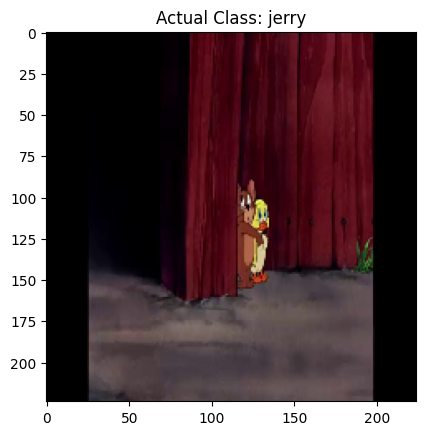

1/1 [==============================] - 0s 85ms/step
Predicted Class: jerry


In [19]:
# Testing image classification model

# Step 1: Randomly select a class from the dataset
random_class = np.random.choice(list(train_generator.class_indices.keys()))
class_path = os.path.join('../Lab_3/tom_and_jerry', random_class)
random_image_path = os.path.join(class_path, np.random.choice(os.listdir(class_path)))

# Step 2: Load and display the selected image
img = image.load_img(random_image_path, target_size=(224, 224)) 
plt.imshow(img)
plt.title('Actual Class: {}'.format(random_class))
plt.show()

# Step 3: Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Step 4: Use the model to make predictions
predictions = model.predict(img_array)

# Step 5: Display the predicted class
predicted_class_index = np.argmax(predictions)
predicted_class = list(train_generator.class_indices.keys())[predicted_class_index]
print(f"Predicted Class: {predicted_class}")

### Recurrent neural network

In [20]:
# Loading dataset from csv
tweet_data = pd.read_csv('../Lab_3/cyberbullying_tweets.csv')

In [21]:
# Showing the dataset
tweet_data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [22]:
# Checking if there are duplicated items
tweet_data.duplicated().sum()

36

In [23]:
# Remove duplicated items
tweet_data.drop_duplicates(inplace=True)

In [24]:
# Function for tweet text preprocessing with cleaning, stop words filtration and stemming
def data_preprocessing(tweet_text):
    # Convert to lowercase
    tweet_text = tweet_text.lower()
    # Remove Twitter usernames
    tweet_text = re.sub('@\S+', ' ', tweet_text)
    # Remove hashtags
    tweet_text = re.sub('#\S+', ' ', tweet_text)
    # Remove URLs
    tweet_text = re.sub('https*\S+', ' ', tweet_text)
    # Remove numbers
    tweet_text = re.sub('\d', ' ', tweet_text)
    # Remove punctuations
    tweet_text = re.sub('[%s]' % re.escape(string.punctuation), ' ', tweet_text)
    # Remove extra spaces
    tweet_text = re.sub('\s{2,}', ' ', tweet_text)
    
    # Stop words filtration
    words = word_tokenize(tweet_text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    processed_tweet = ' '.join(words)
    
    return processed_tweet

In [25]:
# Applying preprocessing
tweet_data['tweet_text'] = tweet_data['tweet_text'].apply(data_preprocessing)

In [26]:
# Splitting data to train and test with 20% test data size
train_df, test_df = train_test_split(tweet_data, test_size=0.2, random_state=42, stratify=tweet_data['cyberbullying_type'])

In [27]:
# Tokenize and pad the text data
max_words = 10000  # Maximum number of words in the vocabulary
max_len = 100  # Maximum length of each sequence
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['tweet_text'])
train_sequences = tokenizer.texts_to_sequences(train_df['tweet_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['tweet_text'])
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [28]:
# Convert class labels to categorical
train_labels = pd.get_dummies(train_df['cyberbullying_type']).values
test_labels = pd.get_dummies(test_df['cyberbullying_type']).values

In [29]:
# Creating model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Train model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
model.fit(train_padded, train_labels, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
954/954 [==============================] - 46s 43ms/step - loss: 0.6370 - accuracy: 0.7250 - val_loss: 0.4717 - val_accuracy: 0.7936
Epoch 2/50
954/954 [==============================] - 40s 42ms/step - loss: 0.3879 - accuracy: 0.8406 - val_loss: 0.4510 - val_accuracy: 0.8195
Epoch 3/50
954/954 [==============================] - 40s 42ms/step - loss: 0.3190 - accuracy: 0.8710 - val_loss: 0.4603 - val_accuracy: 0.8165
Epoch 4/50
954/954 [==============================] - 41s 43ms/step - loss: 0.2745 - accuracy: 0.8886 - val_loss: 0.5048 - val_accuracy: 0.8122
Epoch 5/50
954/954 [==============================] - 40s 42ms/step - loss: 0.2467 - accuracy: 0.8987 - val_loss: 0.5273 - val_accuracy: 0.8117
Epoch 6/50
954/954 [==============================] - 40s 42ms/step - loss: 0.2185 - accuracy: 0.9081 - val_loss: 0.5571 - val_accuracy: 0.8088
Epoch 7/50
954/954 [==============================] - 40s 42ms/step - loss: 0.1929 - accuracy: 0.9165 - val_loss: 0.6309 - val_accuracy:

In [31]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
print(f'Test Accuracy: {test_accuracy}')

298/298 [==============================] - 4s 13ms/step - loss: 0.4556 - accuracy: 0.8116
Test Accuracy: 0.8115820288658142


### Conclusions

**Fully Connected Neural Networks**:
The implementation of fully connected neural networks demonstrated their capacity in capturing intricate patterns within the data. The models exhibited satisfactory accuracy on the test set, indicating their effectiveness in handling classification tasks. Further refinement through fine-tuning and hyperparameter optimization holds promise for enhanced performance.

**Convolutional Neural Networks**:
Convolutional neural networks showcased their prowess in learning hierarchical features from image data. The integration of convolutional and pooling layers allowed for effective image classification. There's potential for improved results by fine-tuning the architecture and incorporating data augmentation techniques.

**Recurrent Neural Networks**:
Recurrent neural networks effectively captured sequential dependencies within text data, making them suitable for text classification tasks. The bidirectional LSTM layer demonstrated the model's ability to understand context and dependencies in both directions. Further exploration involving hyperparameter tuning and alternative architectures could lead to heightened performance.

**General Insights**:

**Data Preprocessing**:
Effective data preprocessing, including tokenization, padding, and normalization, played a pivotal role in model training. Clean and well-prepared data is essential for optimal neural network performance.

**Model Complexity**:
The importance of adjusting model complexity based on the characteristics of the data and the intricacy of the task was evident. A balanced model complexity is crucial for achieving optimal results.

**Hyperparameter Tuning**:
Fine-tuning hyperparameters, such as learning rates and layer dimensions, emerged as a critical aspect of model optimization. Iterative adjustments can significantly impact overall performance.

**Evaluation Metrics**:
The choice of appropriate evaluation metrics beyond accuracy was emphasized. Understanding precision, recall, and F1 score provides a more comprehensive assessment of model effectiveness.

**Further Exploration**:
Encouraging continuous exploration of different architectures, optimization techniques, and preprocessing strategies remains key. Ongoing refinement and experimentation promise the potential for even greater model efficacy.